In [1]:
%pylab inline

from datetime import datetime, timedelta
import astropy
import calendar
from astropy.time import Time,TimezoneInfo,TimeDelta
from astropy import units as u
from astropy import coordinates as co
import pandas as pd
import numpy as np
import pylab as pl
from astroplan import Observer, FixedTarget, is_observable, is_always_observable, months_observable, observability_table
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)


np.random.seed(2)
pd.__version__

Populating the interactive namespace from numpy and matplotlib


'1.3.3'

In [2]:
nnights = 365
max_obs = 60
target = FixedTarget.from_name('HD155060')
t = Time('2021-02-2') + arange(nnights) * u.day # UT date
df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
keck = Observer.at_site("Keck", timezone="US/Hawaii")
sunset = keck.sun_set_time(t,horizon=-12*u.deg,which='next')
sunrise =  keck.sun_rise_time(t,horizon=-12*u.deg, which='next')
moonrise = keck.moon_rise_time(t,horizon=0*u.deg, which='next')
nightlength = (sunrise - sunset)
constraints = [AltitudeConstraint(20*u.deg, 85*u.deg)]

In [3]:
savecols = 'utdate quarter start stop start_jd stop_jd kpfcc dark'.split()

In [4]:
df2 = []
for i in range(1,5):
    df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
    df = pd.DataFrame(dict(utdate=Time(t.to_datetime(timezone=keck.timezone)).to_value('iso','date')))
    df['quarter'] = i
    start = sunset + (i-1) / 4.0 * nightlength
    stop = sunset +  i / 4.0 * nightlength
    df['nightlength'] = nightlength.value
    df['start_jd'] =  start.jd
    df['stop_jd'] = stop.jd
    df['start'] = pd.Series(start.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['stop'] = pd.Series(stop.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['month'] = start.ymdhms['month']
    df['moon_alt_start'] = keck.moon_altaz(start).alt.deg
    df['moon_alt_stop'] = keck.moon_altaz(stop).alt.deg
    df2.append(df)

df = pd.concat(df2)
df = df.sort_values(by=['start_jd'])
df = df.reset_index(drop=True)
df['kpfcc'] = False
df['dark'] = (df.moon_alt_start < 0) & (df.moon_alt_stop < 0)

dark_early = df[df.quarter.isin([1,2])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_late = df[df.quarter.isin([3,4])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_all = df.groupby('utdate').filter(lambda x: x['dark'].sum()==4)


dfrem = df.copy()
rs = 0 
nstart_quarters = len(df)
nkpfcc_quarters = 365 
ndark_quarters = 365 # remove this many quarters for darktime


dfrem = dfrem.drop(dark_all.index,errors='ignore')
dfrem = dfrem.drop(dark_early.index,errors='ignore')
dfrem = dfrem.drop(dark_late.index,errors='ignore')

print("{}/{} quarters remain after dropping dark all, early, late".format(len(dfrem),nstart_quarters))

# schedule 1/8 of nights are first half

for i in range(4):
    if i==0:
        # schedule 1/8 of nights as Q1+Q2
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & (df.quarter.isin([1,2])),'kpfcc'] = True

    if i==1:
        # schedule 1/8 of nights as Q3+Q4
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([3,4]),'kpfcc'] = True

    if i==2:
        # schedule 1/5 of nights as Q1 
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([1]),'kpfcc'] = True

    if i==3:
        # schedule 1/4 of nights as Q4
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([4]),'kpfcc'] = True

    dfrem = dfrem[~dfrem.utdate.isin(dates)]
    

print("{}/{} quarters are KPF-CC".format(df.kpfcc.sum(),nstart_quarters))
print("{}/{} nights KPF-CC onsky".format((df.groupby('utdate')['kpfcc'].sum()>0).sum(),nnights))

# df[savecols].to_csv('kpfcc_schedule_v2.csv')

1012/1460 quarters remain after dropping dark all, early, late
362/1460 quarters are KPF-CC
272/365 nights KPF-CC onsky


/Users/bfulton/anaconda3/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/Users/bfulton/anaconda3/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


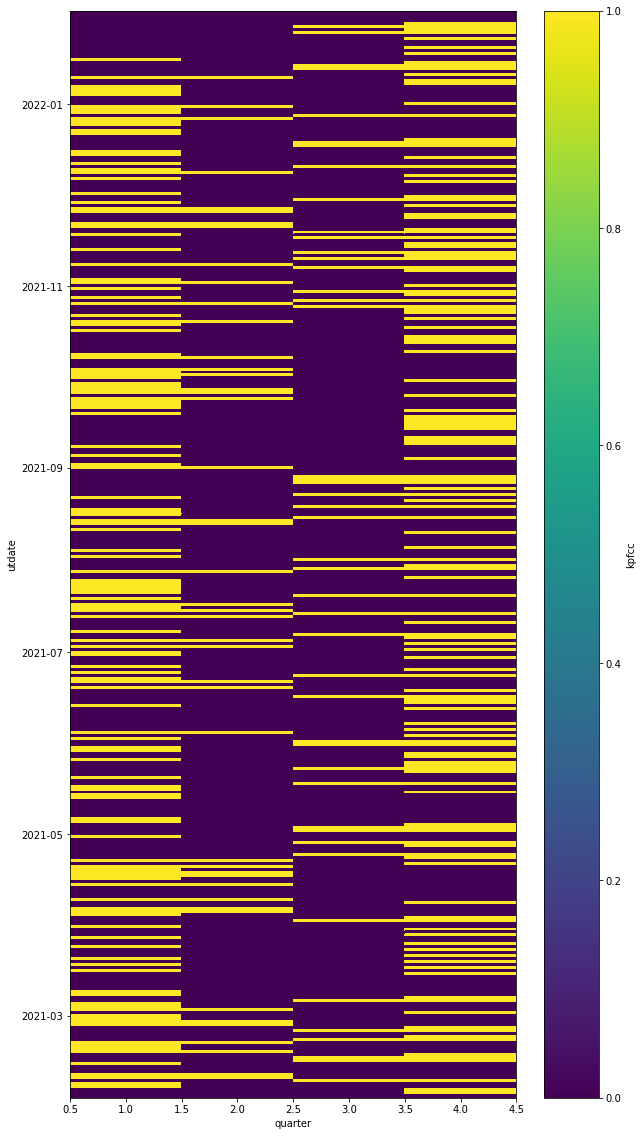

In [5]:
da = df.groupby(['utdate','quarter'])['kpfcc'].first().to_xarray()
da.coords['utdate'] = Time(list(array(da.utdate))).datetime
da.sortby(da.utdate,ascending=False).plot.pcolormesh(figsize=(10,20))

In [6]:
timestamps = []
dates_observed = []
f = open('timestamps_C.csv', 'w')
date_groups = df[df['kpfcc']].groupby('utdate', as_index=False)
for grp in date_groups:
#     if np.random.uniform() > 0.50:  # 33% chance of observing on a given CC night
#         continue
    num = len(grp[1])
    block = grp[1].sample(1)
    date = block['utdate'].values[0]
    if date not in dates_observed:
        obs = Time(np.random.uniform(block.start_jd, block.stop_jd), format='jd')[0]
        if keck.target_is_up(obs, target):
            print(obs, num)
            timestamps.append(obs)
            dates_observed.append(date)
            print(obs, file=f)
        if len(timestamps) >= max_obs:
            break


f.close()
    

2459249.106688459 1
2459250.059417007 1
2459253.09286689 2
2459260.125596199 2
2459261.0190041875 2
2459262.111134746 1
2459266.950185211 2
2459268.1099689654 1
2459270.084943889 2
2459271.0654437374 1
2459276.1148567637 1
2459280.026814646 2
2459281.1220216947 1
2459289.059139398 1
2459291.137326309 1
2459293.0679493668 1
2459295.0775366384 1
2459297.070549879 1
2459299.0796948383 1
2459302.0698245405 1
2459304.1239861357 1
2459307.077082991 2
2459308.127139249 1
2459313.1389600346 1
2459313.8816464585 2
2459320.8061936377 1
2459321.8260970474 2
2459324.8235150143 2
2459326.1029022182 1
2459326.7806885336 2
2459328.063117215 1
2459328.987803917 2
2459332.06854561 1
2459333.0030463687 2
2459334.769926875 1
2459336.964664036 2
2459337.9560520076 2
2459339.084497761 1
2459340.7990041072 1
2459347.7741028676 1
2459348.7849066523 1
2459350.0649792324 1
2459350.771438949 1
2459351.7908531507 1
2459352.9619807624 2
2459354.7755374103 1
2459357.1155770943 1
2459358.094146289 2
2459359.0863235

In [12]:
timestamps = []
f = open('timestamps_A.csv', 'w')

date_groups = df[df['kpfcc']].query('3 <= month <= 10')\
        .sort_values(by='utdate')\
            .groupby('utdate', as_index=False)
random_dates = date_groups.sum().sample(10)['utdate'].values

i = 0
while len(timestamps) < max_obs:
    for grp in date_groups:
        ind = grp[0]
        if ind not in random_dates:
            continue
        num = len(grp[1])
        block = grp[1].sample(1)
        date = block['utdate'].values[0]
        start = "{:s} {:s}".format(date, block.start.values[0])
        end = "{:s} {:s}".format(date, block.stop.values[0])
        range = Time([start, end])
        can_obs = is_observable(constraints, keck, target, range)[0]
        tab = observability_table(constraints, keck, [target], range, time_grid_resolution=60*u.second)
        obs = Time(np.random.uniform(block.start_jd, block.stop_jd), format='jd')[0] + 365*i
        timestamps.append(obs)
        timestamps.append(obs+600/86400)
        timestamps.append(obs+1200/86400)
        print(obs, file=f)
        print(obs+600/86400, file=f)
        print(obs+1200/86400, file=f)
        if len(timestamps) >= max_obs:
            break

        
#         frac = tab['fraction of time observable']
#         hours_observable = ((range[1] - range[0]) * frac) * 24
#         hours_observable = hours_observable[0]
#         print(start, end, hours_observable)
#         if can_obs and hours_observable >= 1:
#             # print(obs, num, can_obs, hours_observable)
#             timestamps.append(obs)
#             print(obs, file=f)
#         if len(timestamps) >= max_obs/3:
#             break
    i+=1

f.close()

<ipython-input-13-d911b7d5a3c9>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
<ipython-input-13-d911b7d5a3c9>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
<ipython-input-13-d911b7d5a3c9>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])


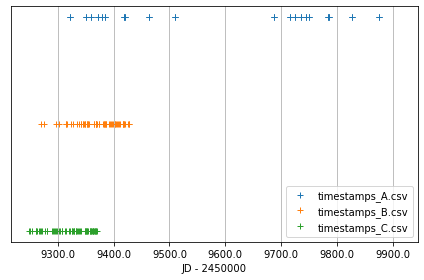

In [13]:
def jd2date(t):
    return Time(t, format='jd').datetime

def date2jd(t):
    try:
        time = Time(t, format='datetime').jd
    except:
        time = Time(2455565, format='jd')
        pass
    return time

i = 0
for fname in ['timestamps_A.csv', 'timestamps_B.csv', 'timestamps_C.csv']:
# for fname in ['timestamps_A.csv']:
    times = pd.read_csv(fname, header=None)
    dts = [jd2date(t[0]) for t in times.values]
    times = [date2jd(t) for t in dts]
    pl.plot(times, np.zeros_like(times)+i, '+', label=fname)
    ax = pl.gca()
    ax.set_xlabel('JD - 2450000')
    ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
    ax.yaxis.set_ticks([])
    ax.set_xlim(Time('2021-01-01', format='iso').jd, Time('2022-12-31', format='iso').jd)
    i -= 1


# axyrs = ax.twiny()
# xl = np.array(list(ax.get_xlim()))
# pl.locator_params(axis='x', nbins=24)
# start = 1
# end = 24
# axyrs.set_xlim(start, end)
# months = [calendar.month_abbr[int(x)] for x in axyrs.get_xticks()] * 2
# axyrs.xaxis.set_ticklabels(months)
# axyrs.set_xlabel('Month', fontweight='bold')

pl.tight_layout()
pl.grid(True)
legend = ax.legend()
pl.savefig('observing_schedule.pdf')
pl.show()


In [27]:
start = "{:s} {:s}".format(block.utdate.values[0], block.start.values[0])
end = "{:s} {:s}".format(block.utdate.values[0], block.stop.values[0])
time_range = Time([start, end])
print(is_observable(constraints, keck, target, time_range))
print(is_always_observable(constraints, keck, target, time_range))
print(observability_table(constraints, keck, [target], time_range))

[ True]
[False]
target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
   HD155060            True             False                         0.5


In [34]:
axyrs.get_xticks([])

<ipython-input-34-960176e4d6cc>:1: MatplotlibDeprecationWarning: Passing the minor parameter of get_ticklocs() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  axyrs.get_xticks([])


array([-0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,
        0.03,  0.04,  0.05,  0.06])

In [26]:
np.random.choice(10, size=10)

array([9, 2, 1, 9, 3, 5, 6, 0, 3, 5])